In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

rawdata = pd.read_csv('data/mobike_shanghai_sample_updated.csv')
rawdata.head()


,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track
0,78387,158357,10080,2016-08-20 06:57,121.348,31.389,2016-08-20 07:04,121.357,31.388,"121.347,31.392#121.348,31.389#121.349,31.390#1..."
1,891333,92776,6605,2016-08-29 19:09,121.508,31.279,2016-08-29 19:31,121.489,31.271,"121.489,31.270#121.489,31.271#121.490,31.270#1..."
2,1106623,152045,8876,2016-08-13 16:17,121.383,31.254,2016-08-13 16:36,121.405,31.248,"121.381,31.251#121.382,31.251#121.382,31.252#1..."
3,1389484,196259,10648,2016-08-23 21:34,121.484,31.320,2016-08-23 21:43,121.471,31.325,"121.471,31.325#121.472,31.325#121.473,31.324#1..."
4,188537,78208,11735,2016-08-16 07:32,121.407,31.292,2016-08-16 07:41,121.418,31.288,"121.407,31.291#121.407,31.292#121.408,31.291#1..."


In [136]:
data = rawdata.copy()
tobestr = ['orderid', 'bikeid', 'userid']
data[tobestr] = data[tobestr].astype('str')
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102361 entries, 0 to 102360
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   orderid           102361 non-null  object        
 1   bikeid            102361 non-null  object        
 2   userid            102361 non-null  object        
 3   start_time        102361 non-null  datetime64[ns]
 4   start_location_x  102361 non-null  float64       
 5   start_location_y  102361 non-null  float64       
 6   end_time          102361 non-null  datetime64[ns]
 7   end_location_x    102361 non-null  float64       
 8   end_location_y    102361 non-null  float64       
 9   track             102361 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(4)
memory usage: 7.8+ MB


In [137]:
data['duration'] = data.end_time - data.start_time
data['dur_day'] = data.duration.apply(lambda x: str(x).split(' ')[0])
data['dur_hr'] = data.duration.apply(lambda x: str(x).split(' ')[-1][:2])
data['dur_min'] = data.duration.apply(lambda x: str(x).split(':')[-2])
data['dur_sec'] = data.duration.apply(lambda x: str(x).split(':')[-1])
tobeint = ['dur_day', 'dur_hr', 'dur_min', 'dur_sec']
data[tobeint] = data[tobeint].astype('int')
data['ttl_min'] = data.dur_day * 24 * 60 + data.dur_hr * 60 + data.dur_min + data.dur_sec / 60

In [138]:
# datetime.datetime.isoweekday（）返回的1-7代表周一--周日；
data['dayId'] = data.start_time.apply(lambda x: x.isoweekday())
#dayType 工作日
data['dayType'] = data.dayId.apply(lambda x: 'weekends' if x == 6 or x == 7 else 'weekdays')

data['hourId'] = data.start_time.apply(lambda x: x.utctimetuple().tm_hour)
# rush hours：7-8，17-20 上班时间 其余时间为non-rush hours
data['hourType'] = data.hourId.apply(lambda x: 'rush hours' if (7 <= x <= 8) or (17 <= x <= 20) else 'non-rush hours')

In [149]:
# 按每条记录的起点位置，作为发起订单所处位置的数据依据
from math import radians, cos, sin, asin, sqrt

# 自定义函数，通过两点的经纬度计算两点之间的直线距离
def geodistance(lng1, lat1, lng2, lat2):
    lng1_r, lat1_r, lng2_r, lat2_r = map(radians, [lng1, lat1, lng2, lat2]) # 经纬度转换成弧度
    dlon = lng1_r - lng2_r
    dlat = lat1_r - lat2_r
    dis = sin(dlat/2)**2 + cos(lat1_r) * cos(lat2_r) * sin(dlon/2)**2
    distance = 2 * asin(sqrt(dis)) * 6371 * 1000 # 地球平均半径为6371km
    distance = round(distance/1000,3)
    return distance

# 自定义函数，通过调用geodistance获取每条记录骑行始末点和起点距中心点的直线距离
def get_dis(item):
    #distance：点和起点距中心点的直线距离
    item['distance'] = geodistance(item['start_location_x'], item['start_location_y'],
                                   item['end_location_x'], item['end_location_y'])    # 计算骑行始末点经纬度的直线距离
    # 国际饭店一般被认为是上海地理中心坐标点，计算骑行起始点经纬度和国际饭店经纬度的直线距离
    #disToCenter：国际饭店的距离
    item['disToCenter'] = geodistance(item['start_location_x'], item['start_location_y'], 121.471632, 31.233705)
    return item

data['distance'] = np.nan
data['disToCenter'] = np.nan
data = data.apply(get_dis, axis=1)



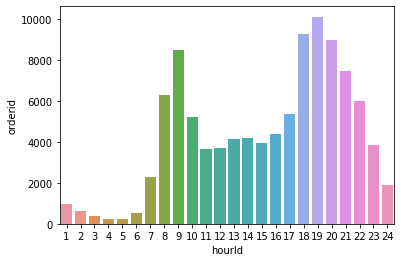

In [151]:
# 时间分布图
import seaborn as sns
data["hourId"] = data["hourId"].apply(lambda x:x+1)
hour_group = data.groupby("hourId")
hour_num_df = hour_group.agg({"orderid":"count"}).reset_index()  # 计算分组后的单车数
# print(hour_num_df)
hour_num_df.to_csv("data/hour_num_df.csv",index=None)
sns.barplot(x = "hourId",y = "orderid",data =hour_num_df )

Text(0.5, 0, 'Riding Distance (km)')

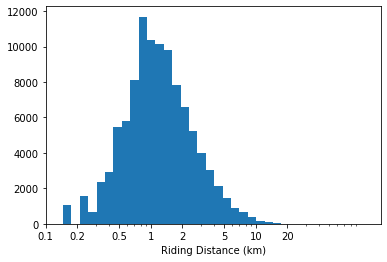

In [141]:
# 骑行距离同样存在长尾分布特征，对x轴使用log变化以观察分布规律
bins = 10 ** np.arange(np.log10(data.distance.min()), np.log10(data.distance.max()) + 0.08, 0.08)
plt.hist(data = data, x = 'distance', bins = bins)
plt.xscale('log')
xticks = (0.1, 0.2, 0.5, 1, 2, 5, 10, 20)
plt.xticks(xticks, xticks)
plt.xlabel('Riding Distance (km)')

In [160]:
# 骑行时间分布图
# 观察到数据分布存在明显的长尾，对x轴使用log变化以观察分布规律
# bins = 10 ** np.arange(0, np.log10(data.ttl_min.max()) + 0.15, 0.15)
# 
# plt.hist(data = data, x = 'ttl_min', bins = bins)  # bins 判断一共有几个柱状条
# plt.xscale('log') 
# xticks = (1, 2, 5, 10, 20, 50, 100, 200, 500)
# plt.xticks(xticks, xticks)
# plt.xlabel('Riding Duration (min)')


TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

In [70]:
data.head(0)

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track,...,dur_hr,dur_min,dur_sec,ttl_min,dayId,dayType,hourId,hourType,distance,disToCenter


In [111]:
data1 = pd.read_csv("data/hour_num_df.csv")

data1

,hourId,orderid
0,1,945
1,2,606
2,3,399
3,4,227
4,5,231
5,6,513
6,7,2297
7,8,6315
8,9,8490
9,10,5208


In [127]:
print(hour_group.head())
hour_num_df

      orderid  bikeid userid          start_time  start_location_x  \
0       78387  158357  10080 2016-08-20 06:57:00           121.348   
1      891333   92776   6605 2016-08-29 19:09:00           121.508   
2     1106623  152045   8876 2016-08-13 16:17:00           121.383   
3     1389484  196259  10648 2016-08-23 21:34:00           121.484   
4      188537   78208  11735 2016-08-16 07:32:00           121.407   
...       ...     ...    ...                 ...               ...   
1044  1557911  308202    664 2016-08-26 04:58:00           121.489   
1103   290757  196551  16640 2016-08-24 04:06:00           121.473   
1356   133643  174811   5669 2016-08-17 03:13:00           121.423   
1893    69913   41472   4933 2016-08-07 03:06:00           121.490   
2201    18775  197910   7996 2016-08-18 03:45:00           121.373   

      start_location_y            end_time  end_location_x  end_location_y  \
0               31.389 2016-08-20 07:04:00         121.357          31.388   
1  

,hourId,orderid
0,1,945
1,2,606
2,3,399
3,4,227
4,5,231
5,6,513
6,7,2297
7,8,6315
8,9,8490
9,10,5208
